##  Import Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Load Processed Data

In [3]:
df = pd.read_csv('../data/processed/vendor_data_processed.csv')

## Select features for clustering

In [4]:
print(df.columns.tolist())

['Transaction_ID', 'Vendor_Name', 'Award_Amount', 'Award_Agency', 'Award_Date', 'Award_Type', 'Performance_Country', 'Performance_State', 'Log_Award_Amount', 'Award_Agency_Code', 'Award_Type_Code', 'Performance_Country_Code', 'Performance_State_Code']


In [5]:
features = [
    'Log_Award_Amount',           # How much money they got (log scale)
    'Award_Agency_Code',          # Which agency gave the award
    'Award_Type_Code',            # What type of award
    'Performance_Country_Code',   # Where work was done (country)
    'Performance_State_Code'      # Where work was done (state)
]

X = df[features]

## Normalize data

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Elbow Method to find optimal k

In [7]:
# # Limit CPU usage for joblib (used by scikit-learn) to avoid WinError on systems without 'wmic'
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

In [8]:
sse = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

## Plot Elbow

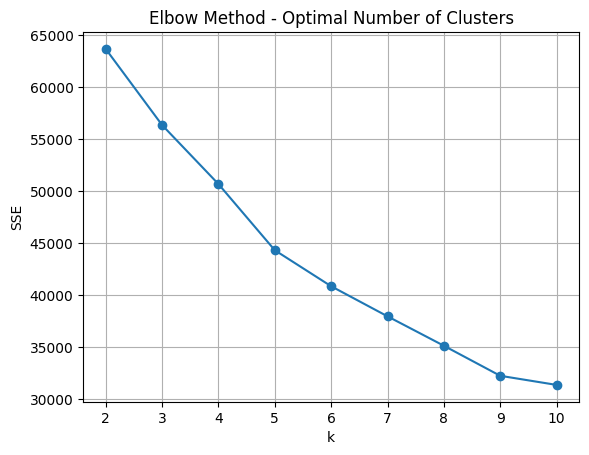

In [9]:
plt.plot(k_range, sse, marker='o')
plt.title("Elbow Method - Optimal Number of Clusters")
plt.xlabel("k")
plt.ylabel("SSE")
plt.grid(True)
plt.show()

## Apply KMeans with chosen k (k = 4)

In [10]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

## Silhouette Score

In [11]:
sil_score = silhouette_score(X_scaled, df['Cluster'])
print(f"Silhouette Score for k={k}: {sil_score:.2f}")

Silhouette Score for k=4: 0.16


## PCA for 2D visualization

In [12]:
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
df['PCA1'] = pca_components[:, 0]
df['PCA2'] = pca_components[:, 1]

## Visualize clusters

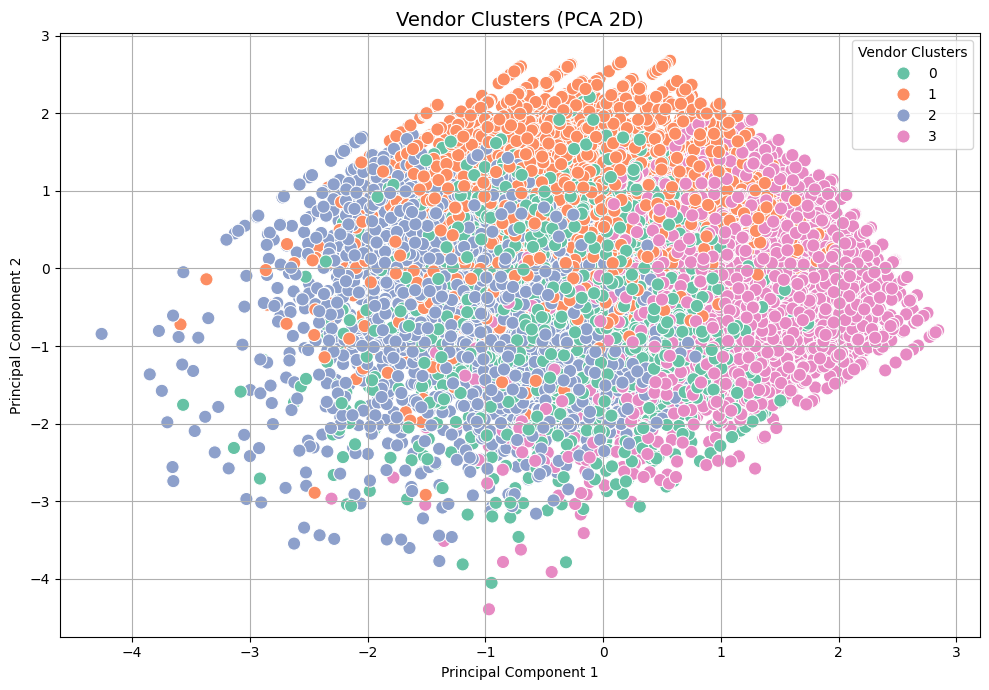

In [13]:
from turtle import title


plt.figure(figsize=(10, 7))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=90)
plt.title("Vendor Clusters (PCA 2D)", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Vendor Clusters", loc='upper right')
plt.grid(True)
plt.grid(True)
plt.tight_layout()
plt.show()

## Added Cluster Summaries

In [14]:
cluster_summary = df.groupby('Cluster')[[
    'Award_Amount', 
    'Award_Agency_Code', 
    'Performance_Country_Code'
]].mean().round(2)

print(cluster_summary)

         Award_Amount  Award_Agency_Code  Performance_Country_Code
Cluster                                                           
0          2491692.25               3.32                      0.34
1          2550950.60               4.92                      1.68
2          2461065.45               2.82                      0.34
3          2494938.86               1.10                      1.66


## Saved the new dataset with clusters

In [15]:
df.to_csv('../data/processed/vendor_data_with_clusters.csv', index=False)
print("✅ File saved with cluster labels.")

✅ File saved with cluster labels.


## Import Clustering Function from pipeline

In [18]:
import sys
import os
sys.path.append(os.path.abspath("../"))  # Add project root to path

from src.clustering_models import run_kmeans, elbow_plot, calculate_silhouette, reduce_pca


## Apply KMeans Clustering: 
### Includes Elbow Method, Model Fitting, Silhouette Evaluation, and PCA Reduction

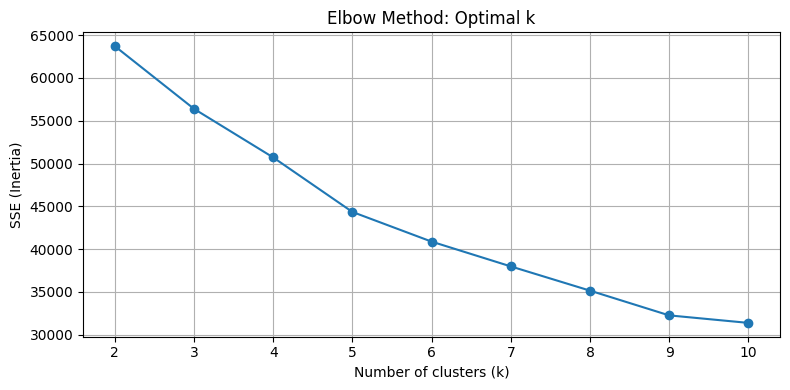

Silhouette Score: 0.156


In [19]:
# Elbow method
elbow_plot(X_scaled)

# Fit KMeans
kmeans_model, labels = run_kmeans(X_scaled, n_clusters=4)
df['Cluster'] = labels

# Silhouette score
score = calculate_silhouette(X_scaled, labels)
print("Silhouette Score:", score)

# PCA reduction
pca_df = reduce_pca(X_scaled)
df[['PCA1', 'PCA2']] = pca_df


## Visualize results with Seaborn

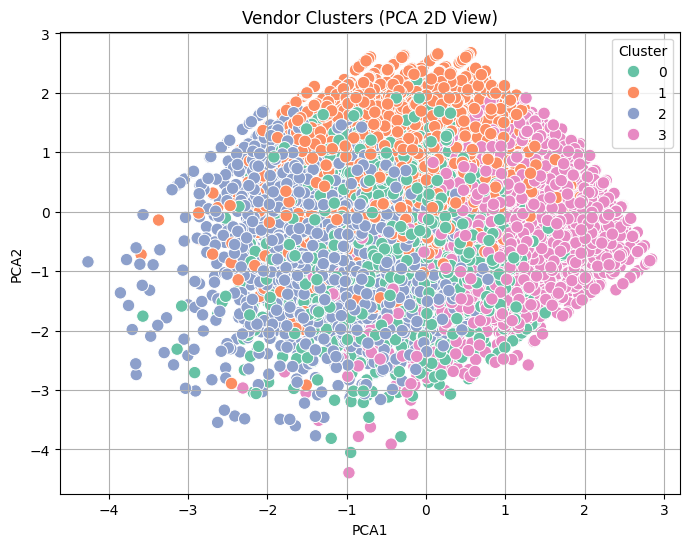

In [20]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='PCA1', y='PCA2', hue='Cluster', palette='Set2', s=80)
plt.title("Vendor Clusters (PCA 2D View)")
plt.grid(True)
plt.show()

## Save Results

In [21]:
df.to_csv("../data/processed/vendor_data_with_clusters.csv", index=False)